In [42]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

ARCHIVO_METRICAS = Path("metrics_red_neuronal.csv")

def agregar_metrica(modelo, experimento, accuracy_train, accuracy_test,
                    recall_train_weighted,recall_test_weighted, f1_train_weighted, f1_test_weighted,
                    tiempo_entrenamiento_seg, overfitting, observaciones,
                    archivo=ARCHIVO_METRICAS):
    """
    Agrega una nueva fila de métricas al archivo CSV.
    Si el archivo no existe, lo crea con las columnas estándar.
    """

    # Crear DataFrame de la nueva fila
    nueva_fila = pd.DataFrame([{
        "modelo": modelo,
        "experimento": experimento,
        "accuracy_train": accuracy_train,
        "accuracy_test": accuracy_test,
        "recall_train_avg": recall_train_weighted,
        "recall_test_avg": recall_test_weighted,
        "f1_train_avg": f1_train_weighted,
        "f1_test_avg": f1_test_weighted,
        "tiempo_entrenamiento_seg": tiempo_entrenamiento_seg,
        "overfitting": overfitting,
        "observaciones": observaciones
    }])

    # Si el archivo ya existe, cargarlo y agregar la fila
    if archivo.exists():
        df = pd.read_csv(archivo)
        indices_a_actualizar = df[df["experimento"] == experimento].index
        if not indices_a_actualizar.empty:
            df.loc[indices_a_actualizar, nueva_fila.columns] = nueva_fila.iloc[0].values
        else:
            df = pd.concat([df, nueva_fila], ignore_index=True)
    else:
        df = nueva_fila

    # Guardar el archivo actualizado
    df.to_csv(archivo, index=False)
    print(f"Métrica agregada correctamente a {archivo}")

def calcular_metricas_keras(modelo, X_train, y_train, X_test, y_test):
    """Calcula métricas para un conjunto dado usando el modelo Keras."""
    from sklearn.metrics import accuracy_score, recall_score, f1_score
    
    # 1. Predecir y convertir a etiquetas discretas
    y_pred_probs_train = modelo.predict(X_train, verbose=0)
    y_pred_probs_test = modelo.predict(X_test, verbose=0)   
    y_pred_train = np.argmax(y_pred_probs_train, axis=1)
    y_pred_test = np.argmax(y_pred_probs_test, axis=1)
    
    # 2. Calcular métricas
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_w_train = recall_score(y_train, y_pred_train, average='weighted')
    f1_w_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    recall_w_test = recall_score(y_test, y_pred_test, average='weighted')
    f1_w_test = f1_score(y_test, y_pred_test, average='weighted')

    print("="*60)
    print("RESULTADOS FINALES DEL MODELO")
    print("="*60)
    print(f"Accuracy (train): {accuracy_train:.4f}")
    print(f"Recall (train): {recall_w_train:.4f}")
    print(f"F1-score (train): {f1_w_train:.4f}")
    print("="*60)
    print(f"Accuracy (test): {accuracy_test:.4f}")
    print(f"Recall (test): {recall_w_test:.4f}")
    print(f"F1-score (test): {f1_w_test:.4f}")
    print("="*60)

    return y_pred_train,y_pred_test,accuracy_train,accuracy_test,recall_w_train,recall_w_test,f1_w_train,f1_w_test

# **Tabla de contenidos**
***
Redes Neuronales (MLP)
1.  Modelo 1 (baseline)

    1.1. Creación del modelo baseline

    1.2. Evaluación del modelo baseline

2.  Modelo 2 (class_weights)

    2.1. Creación del modelo 2

    2.2. Evaluación del modelo 2
    
3.  Modelo 3 (SMOTE)

    3.1. Creación del modelo 3

    3.2. Evaluación del modelo 3

4.  Modelo 4 (SMOTETomek)

    4.1. Creación del modelo 4

    4.2. Evaluación del modelo 4

5.  Evaluación general y conclusiones

***

# **Redes Neuronales** (MLP)

Un **modelo MLP** *(perceptrón multicapa)* es una clase de red neuronal que se caracteriza por estar inspirado en las neuronas biológicas y su principal cometido es la **clasificación de datos**.

En nuestro caso vamos a utilizar un modelo MLP para predecir y **clasificar el tipo de crimen más probable que le ocurra a una víctima** dependiendo de los siguientes datos:

In [43]:
X_train = pd.read_csv("../../../data/x_train.csv")
X_test = pd.read_csv("../../../data/x_test.csv")
y_train = pd.read_csv("../../../data/y_train.csv")
y_test = pd.read_csv("../../../data/y_test.csv")

Nuestras **variables predictoras** son:

In [44]:
print(f"Variables predictoras:\n")
print(X_train.describe().T)

Variables predictoras:

                                                    count unique    top   freq
ager_18-24                                          44702      2  False  36809
ager_25-34                                          44702      2  False  35387
ager_35-49                                          44702      2  False  33479
ager_50-64                                          44702      2  False  37721
ager_65+                                            44702      2  False  42535
sex_Male                                            44702      2   True  22657
race_ethnicity_Non-Hispanic American Indian/Ala...  44702      2  False  44208
race_ethnicity_Non-Hispanic Asian/Native Hawaii...  44702      2  False  43616
race_ethnicity_Non-Hispanic black                   44702      2  False  39169
race_ethnicity_Non-Hispanic more than one race      44702      2  False  43735
race_ethnicity_Non-Hispanic white                   44702      2   True  30622
hincome1_$25,000 to $34,999 

En este caso la **variable a predecir** seria *'newoff'*:

In [45]:
print(f"Variable a predecir:\n")
print(f"{y_train.info()}\n")
print(f"Valores en la variable a predecir:\n")
print(y_train['newoff'].value_counts())

Variable a predecir:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44702 entries, 0 to 44701
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   newoff  44702 non-null  int64
dtypes: int64(1)
memory usage: 349.4 KB
None

Valores en la variable a predecir:

newoff
4    27850
3     8460
2     4634
1     2440
5     1318
Name: count, dtype: int64


Nuestros DataFrames tienen la siguiente **dimensionalidad**:

In [46]:
print("Dimensionalidad de X_train:", X_train.shape)
print("Dimensionalidad de y_train:", y_train.shape)
print("Dimensionalidad de X_test:", X_test.shape)
print("Dimensionalidad de y_test:", y_test.shape)

Dimensionalidad de X_train: (44702, 42)
Dimensionalidad de y_train: (44702, 1)
Dimensionalidad de X_test: (11176, 42)
Dimensionalidad de y_test: (11176, 1)


Teniendo esto en cuenta podemos hacer las siguientes presunciones:

1. La dimensionalidad de la capa de entrada siempre va a ser:  
$$
n_{\text{features}} = X_{\text{train}}.shape[1]
$$


In [47]:
print(f"Dimensionalidad de la capa de entrada: ({X_train.shape[1]},)")

Dimensionalidad de la capa de entrada: (42,)


2. Las capas ocultas utilizarán la función de activación *ReLU*:
$$
\text{ReLU}(x) = \max(0, x)
$$


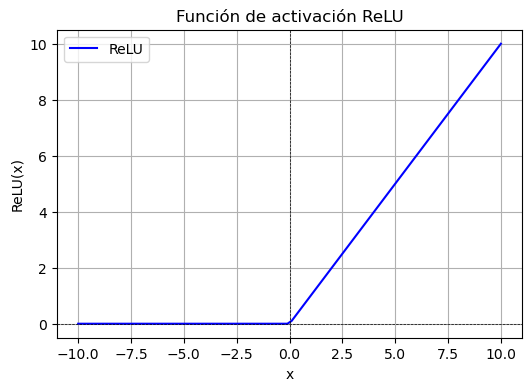

In [48]:
plt.figure(figsize=(6,4))
plt.title("Función de activación ReLU")
x = np.linspace(-10, 10, 100)
y = np.maximum(0, x)
plt.plot(x, y, label='ReLU', color='blue')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.legend()
plt.grid()
plt.show()

3. Como estamos haciendo una red neuronal para clasificación multiclase la función de activación de la capa de salida será *Softmax*:
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}, \quad i = 1, \dots, K
$$


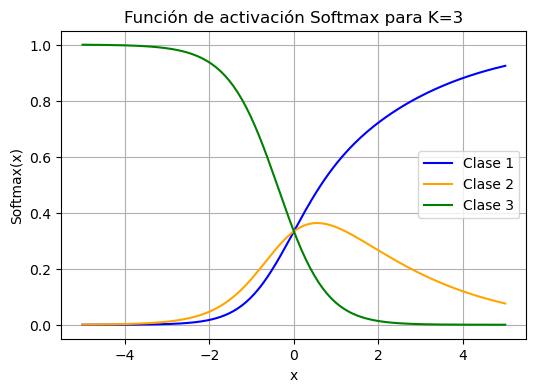

In [49]:
plt.figure(figsize=(6,4))
plt.title("Función de activación Softmax para K=3")

x = np.linspace(-5, 5, 200)

# Definimos tres "neuronas" con pendientes distintas
z1 = x
z2 = 0.5 * x
z3 = -x

# Calculamos softmax para cada punto x
exp_z = np.exp(np.vstack([z1, z2, z3]))
softmax = exp_z / np.sum(exp_z, axis=0)

# Graficamos
plt.plot(x, softmax[0], label='Clase 1', color='blue')
plt.plot(x, softmax[1], label='Clase 2', color='orange')
plt.plot(x, softmax[2], label='Clase 3', color='green')
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.legend()
plt.grid(True)
plt.show()

4. Como pasamos los resultados en forma de índice y no en OHE, la función de pérdida utilizada será la entropía cruzada categórica dispersa *(sparse categorical cross-entropy)*:
$$
L = -\frac{1}{N} \sum_{i=1}^{N} \log p_{i, y_i}
$$

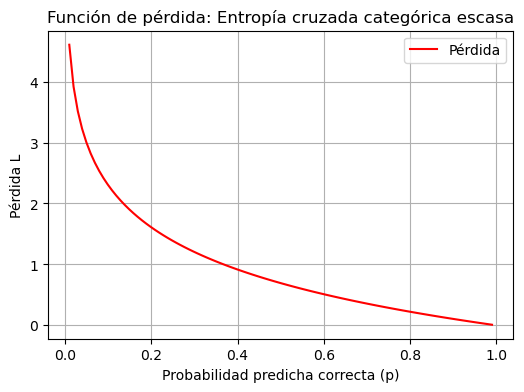

In [50]:
plt.figure(figsize=(6,4))
plt.title("Función de pérdida: Entropía cruzada categórica escasa")
p = np.linspace(0.01, 0.99, 100)
L = -np.log(p)
plt.plot(p, L, label='Pérdida', color='red')
plt.xlabel('Probabilidad predicha correcta (p)')
plt.ylabel('Pérdida L')
plt.legend()
plt.grid()
plt.show()

## 1. Modelo 1 (baseline)

El primer modelo lo vamos a usar como una base para los otros, por esta razón vamos a crearlo con una estructura muy simple.  
En este caso nuestro modelo ***baseline*** se compone de:

Tabla de especificaciones modelo baseline:
| Especificación | Detalle | Valor Usado |
| :---: | :--- | :--- |
| **Arquitectura** | Capas Densas | 2 Capas (1 Oculta, 1 Salida) |
| **Capa Oculta** | Número de neuronas | **32** neuronas |
| **Activación (Oculta)** | Tipo de activación | **ReLU** |
| **Capa de Salida** | Tipo de Clasificación | **5** neuronas con **Softmax** |
| **Regularización** | Dropout / L2 | **No** se utiliza |
| **Normalización** | BatchNormalization | **No** se utiliza |
| **Manejo de Desbalance** | Técnica utilizada | **No** se utiliza |
| **Optimizador** | Tipo | **Adam** (configuración por defecto) |
| **Función de Pérdida** | Loss Function | **`sparse_categorical_crossentropy`** |
| **Métrica de Monitoreo** | Métrica Clave | **Accuracy** |
| **EarlyStopping** | Utilizado | **No** se utiliza |
| **Épocas** | Número de iteraciones | **20** |
| **Tamaño de Lote (Batch)** | Batch size | **32** |
| **Split de Validación** | Porcentaje de `validation_split` | **0.2** (20% de `X_train`) |
| **Datos de Entrenamiento** | Datos fuente | Datos Originales (`X_train`) |

### 1.1. Creación modelo baseline


In [51]:
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

#Pasar de 1-5 a 0-4
y_train = y_train-1
y_test = y_test-1

# Modelo simple
model_baseline = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(5, activation="softmax")
])

model_baseline.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

inicio = time.time()
history_baseline = model_baseline.fit(X_train, y_train,
                                   validation_split=0.2,
                                   epochs=20,
                                   batch_size=32,
                                   verbose=1)
fin = time.time()
tiempo_entrenamiento = fin - inicio


Epoch 1/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6214 - loss: 1.0800 - val_accuracy: 0.6263 - val_loss: 1.0420
Epoch 2/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6225 - loss: 1.0394 - val_accuracy: 0.6262 - val_loss: 1.0362
Epoch 3/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6230 - loss: 1.0331 - val_accuracy: 0.6269 - val_loss: 1.0361
Epoch 4/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6232 - loss: 1.0300 - val_accuracy: 0.6271 - val_loss: 1.0354
Epoch 5/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6246 - loss: 1.0273 - val_accuracy: 0.6280 - val_loss: 1.0339
Epoch 6/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6244 - loss: 1.0247 - val_accuracy: 0.6269 - val_loss: 1.0328
Epoch 7/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6250 - loss: 1.0229 - val_accuracy: 0.6283 - val_loss: 1.0314
Epoch 8/20
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6252 - loss: 1.0207 - 

In [52]:
print(f"Tiempo de entrenamiento (segundos): {tiempo_entrenamiento:.2f}")
observaciones = "Modelo básico con 2 capas densas y función de activación ReLU en la capa oculta y Softmax en la capa de salida. Entrenado por 20 épocas con Adam default."
y_pred_train,y_pred_test,accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test = calcular_metricas_keras(model_baseline, X_train, y_train, X_test, y_test)
agregar_metrica('Modelo Red Neuronal', 'Baseline',accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,tiempo_entrenamiento,overfitting='Si',observaciones=observaciones)

Tiempo de entrenamiento (segundos): 54.14
RESULTADOS FINALES DEL MODELO
Accuracy (train): 0.6270
Recall (train): 0.6270
F1-score (train): 0.5125
Accuracy (test): 0.6208
Recall (test): 0.6208
F1-score (test): 0.5053
Métrica agregada correctamente a metrics_red_neuronal.csv


### 1.2. Evaluación modelo baseline

Train Accuracy: 0.6270 (62.70%)
Train Loss: 1.0124
Test Accuracy: 0.6208 (62.08%)
Test Loss: 1.0408


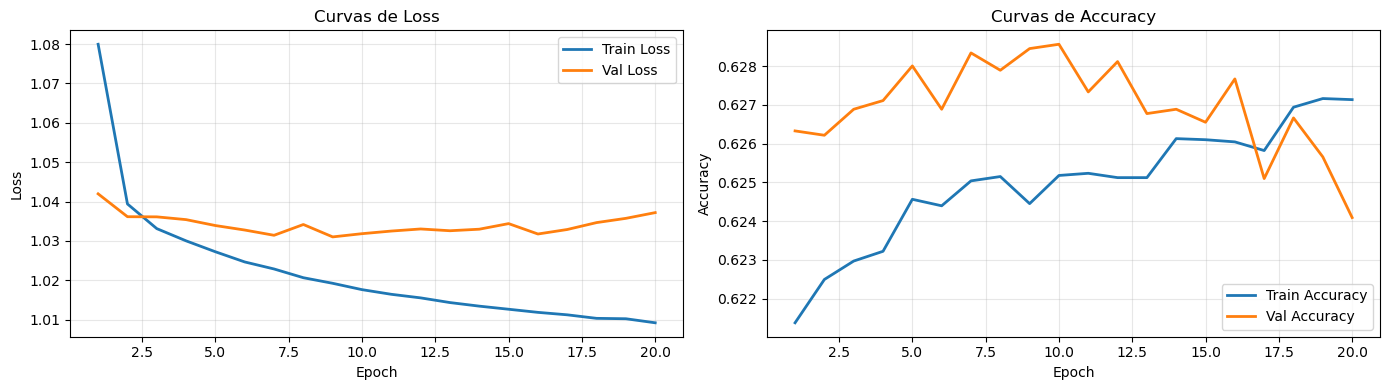

In [53]:
# Evaluar train

train_loss, train_acc = model_baseline.evaluate(X_train, y_train, verbose=0)

print(f"Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Train Loss: {train_loss:.4f}")

# Evaluar test

test_loss, test_acc = model_baseline.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Visualización de curvas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs (1 a 20, no 0 a 19)
epochs = range(1, len(history_baseline.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_baseline.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_baseline.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(epochs, history_baseline.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history_baseline.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Curvas de Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

La disminución del Train Loss mientras el Val Loss se estanca podría ser un indicio de un ligero **sobreajuste (overfitting)**. El modelo está memorizando mejor los datos de entrenamiento, pero **no mejora su capacidad de generalización** a datos no vistos (validación). El **rendimiento global** es **bajo** (entorno al 62%).

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


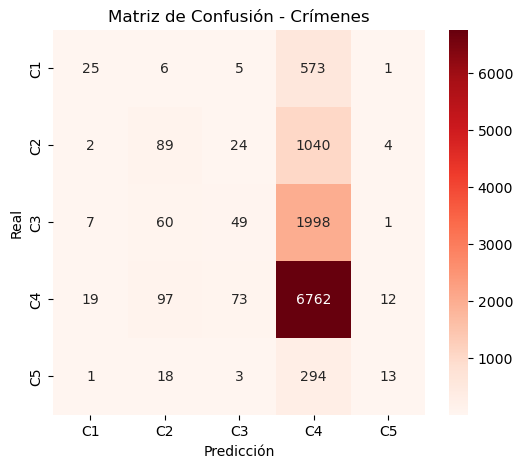


 Classification Report:
              precision    recall  f1-score   support

          C1       0.46      0.04      0.08       610
          C2       0.33      0.08      0.12      1159
          C3       0.32      0.02      0.04      2115
          C4       0.63      0.97      0.77      6963
          C5       0.42      0.04      0.07       329

    accuracy                           0.62     11176
   macro avg       0.43      0.23      0.22     11176
weighted avg       0.53      0.62      0.51     11176



In [54]:
# Matriz de confusión
y_pred_crime = model_baseline.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

Analizando el *classification report* podemos sacar otras conclusiones. Podemos ver que el modelo tiene un claro **sesgo hacia la clase 4** (C4) y en la mayoría de las ocasiones decide predecir ese resultado sin tener en cuenta las demás clases. Esto se puede deber a que tenemos un **desbalanceo en las clases** (tenemos muchos mas datos de la clase 4 que de las demás) y esto hace que el modelo crea que la **solución mas sencilla es predecir la clase 4** sin importar qué datos se le den.  

Para intentar mejorar el modelo podemos intentar lo siguiente:
- Cambiar la metrica a *'f1-score'* de evaluación para combatir las clases desbalanceadas.
- Usar *'class_weights'* en la función de perdida para penalizar más los errores en las clases minoritarias.

## 2. Modelo 2 (class_weights)

Tabla de especificaciones modelo 2:
| Especificación | Detalle | Valor Usado |
| :---: | :--- | :--- |
| **Arquitectura** | Capas Densas/Activación | 4 Capas (1 Input, 3 Ocultas) |
| **Capas Ocultas** | Número de neuronas | 128, 64, 32 neuronas |
| **Activación (Ocultas)** | Tipo de activación | **ReLU** |
| **Capa de Salida** | Tipo de Clasificación | 5 neuronas (Clases) con **Softmax** |
| **Regularización** | Dropout / L2 | **No** se utiliza |
| **Normalización** | BatchNormalization | **No** se utiliza |
| **Manejo de Desbalance** | Técnica utilizada | **`class_weight`** (pesos de clase balanceados) |
| **Optimizador** | Tipo | **Adam** (configuración por defecto) |
| **Función de Pérdida** | Loss Function | **`sparse_categorical_crossentropy`** |
| **Métrica de Monitoreo** | Métrica Clave | **F1-Score (weighted)** (a través de Callback) |
| **EarlyStopping** | Utilizado | **No** se utiliza |
| **Épocas** | Número de iteraciones | **20** |
| **Tamaño de Lote (Batch)** | Batch size | **32** |
| **Datos de Entrenamiento** | Datos fuente | Datos Originales (`X_train`) |

### 2.1. Creación modelo 2

In [55]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import Callback

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
        f1 = f1_score(self.y_val, y_pred, average='weighted')
        self.f1_scores.append(f1)
        print(f" — val_f1: {f1:.4f}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train["newoff"].values),
    y=y_train["newoff"].values
)
class_weight_dict = dict(enumerate(class_weights))

model2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[]
)

f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))

inicio = time.time()
history_model2 = model2.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[f1_callback],
    verbose=1
)
fin = time.time()
tiempo_entrenamiento = fin - inicio

Epoch 1/20
1385/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4817 — val_f1: 0.3228
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4515 - val_loss: 1.4874
Epoch 2/20
1387/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4089 — val_f1: 0.3384
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4058 - val_loss: 1.4597
Epoch 3/20
1372/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3849 — val_f1: 0.2804
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3885 - val_loss: 1.5328
Epoch 4/20
1373/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3943 — val_f1: 0.2710
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.3745 - val_loss: 1.5205
Epoch 5/20
1395/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3482 — val_f1: 0.3025
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3580 - val_loss: 1.4967
Epoch 6/20
1383/1397 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3273 — val_f1: 0.3575
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3420 - val_loss: 1.4739
Epoch 7/20
1365/1397 ━

In [56]:
print(f"Tiempo de entrenamiento (segundos): {tiempo_entrenamiento:.2f}")
observaciones = "Modelo 2. 3 capas ocultas y función de activación ReLU. Entrenado por 20 épocas con Adam y pesos ajustados por clase."
y_pred_train,y_pred_test,accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test = calcular_metricas_keras(model2, X_train, y_train, X_test, y_test)
agregar_metrica('Modelo Red Neuronal', 'Modelo 2',accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,tiempo_entrenamiento,overfitting='Si',observaciones=observaciones)

Tiempo de entrenamiento (segundos): 125.99
RESULTADOS FINALES DEL MODELO
Accuracy (train): 0.3795
Recall (train): 0.3795
F1-score (train): 0.3998
Accuracy (test): 0.3124
Recall (test): 0.3124
F1-score (test): 0.3516
Métrica agregada correctamente a metrics_red_neuronal.csv


### 2.2. Evaluación modelo 2

Train Loss: 1.2942
Test Loss: 1.5044


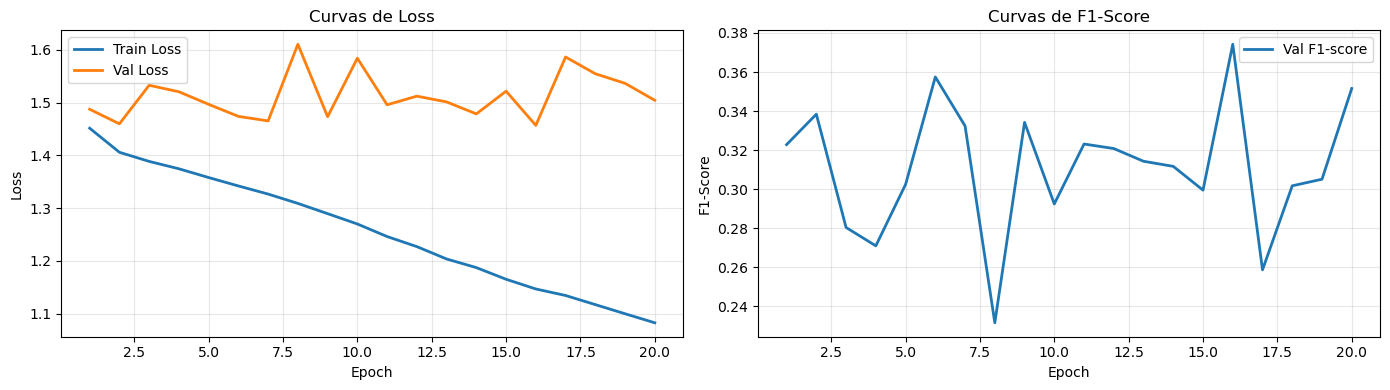

In [57]:
# Evaluar train

train_loss = model2.evaluate(X_train, y_train, verbose=0)

print(f"Train Loss: {train_loss:.4f}")

# Evaluar test

test_loss = model2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")

# Visualización de curvas de entrenamiento
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs (1 a 20, no 0 a 19)
epochs = range(1, len(history_model2.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_model2.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_model2.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, f1_callback.f1_scores, label='Val F1-score', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-Score')
ax2.set_title('Curvas de F1-Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Viendo el gráfico de *loss* podemos decir que ahora tenemos **aún más sobreajuste** (overfitting), ya que en train la pérdida baja según avanzan las épocas, pero en val sube. Esto quiere decir que **el modelo no generaliza bien**.  

Esto se puede deber a que estamos "obligando" al modelo a darle menos importancia a la clase predominante (clase 4) mediante el **cambio del peso** de cada clase y por esto está intentado darle la **misma importancia a todas las clases**, aunque en realidad gran parte de las predicciones reales pertezcan a la clase 4.

En el gráfico de *f1-score* podemos ver cómo **varía constantemente** entre las épocas. Esto nos dice que **el modelo no consigue una clasificación precisa**, y hay alguna clase que domina las predicciones

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


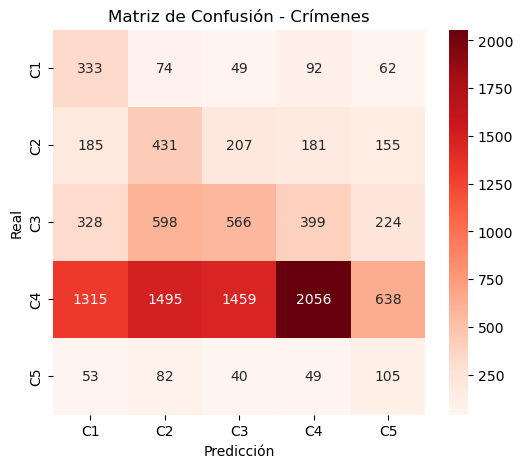


 Classification Report:
              precision    recall  f1-score   support

          C1       0.15      0.55      0.24       610
          C2       0.16      0.37      0.22      1159
          C3       0.24      0.27      0.26      2115
          C4       0.74      0.30      0.42      6963
          C5       0.09      0.32      0.14       329

    accuracy                           0.31     11176
   macro avg       0.28      0.36      0.26     11176
weighted avg       0.53      0.31      0.35     11176



In [58]:
# Matriz de confusión
y_pred_crime = model2.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

En la *matriz de confusión* podemos ver que en los resultados reales **la clase 4 (C4) predomina**, pero **el modelo está intentando darle la misma importancia que a las demás clases** en las predicciones y por eso su precisión no es buena.  

Teniendo en cuenta que nuestro mayor problema es el desbalanceo de clases tenemos dos opciones para intentar mejorar el rendimiento del modelo. Podemos intentar **aumentar el número de datos que tenemos de las clases minoritarias creando datos sintéticos** (SMOTE) o podemos **quitar datos de la clase predominante (Clase 4) y aumentar su peso para simular la distribución real** (Undersampling).  

Como las clases minoritarias ya tienen pocos datos, **no tendría sentido quitar más datos del dataset** asi que vamos a utilizar **SMOTE** para agregar datos sinteticos al dataset y así intentar que el modelo aprenda de ellos.

Para intentar mejorar el modelo vamos a hacer los siguientes cambios en el Modelo 3:

- Añadir Dropout para evitar overfitting
- Aumentar las épocas e implementar EarlyStopping para detener el entrenamiento en caso de que empeore
- Implementar SMOTE para intentar minimizar el desbalanceo de clases
- Implementar BatchNormalization para mejorar la estabilidad en el modelo y evitar las fluctuaciones en validación
- Configurar el learning-rate con el optimizador Adam
- Añadir ReduceLROnPlateau para reducir la tasa de aprendizaje segun el avance del modelo
- Subir las épocas a 200 para complementar el EarlyStopping
- Subir el tamaño del lote (batch_size) a 256 para que tenga mas muestras por época

## 3. Modelo 3 (SMOTE)

Tabla de especificaciones modelo 3:
| Especificación | Detalle | Valor Usado |
| :---: | :--- | :--- |
| **Arquitectura** | Capas Densas/Activación | 4 Capas (128, 64, 48, 32) con **ReLU** |
| **Capa de Salida** | Tipo de Clasificación | 5 neuronas con **Softmax** |
| **Regularización** | Dropout (en capas ocultas) | **0.5** (en las 4 capas) |
| **Normalización** | BatchNormalization | Sí (para estabilidad) |
| **Manejo de Desbalance** | Técnica de Preprocesamiento | **SMOTE** |
| **Optimizador** | Tipo y Tasa de Aprendizaje | **Adam** con $LR = 5e^{-4}$ |
| **Función de Pérdida** | Loss Function | **sparse\_categorical\_crossentropy** |
| **Métrica de Monitoreo** | Métrica Clave | **F1-Score (weighted)** |
| **EarlyStopping** | Monitoreo y Paciencia | `val_f1` (modo 'max'), paciencia **10** |
| **Learning Rate Sched.** | Reducción de Tasa de Aprendizaje | `ReduceLROnPlateau` (factor **0.5**, paciencia **10**) |
| **Épocas** | Máximo de iteraciones | **200** |
| **Tamaño de Lote (Batch)** | Batch size | **256** |



### 3.1. Creación modelo 3

In [59]:
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train.astype(float), y_train.astype(int))
X_train_res = X_train_res.astype(float) 
y_train_res = y_train_res.astype(int)

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
        f1 = f1_score(self.y_val, y_pred, average='weighted')
        self.f1_scores.append(f1)
        logs["val_f1"] = f1
        print(f" — val_f1: {f1:.4f}")

model3 = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(48, activation='relu'), 
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(5, activation='softmax')
])

optimizador = Adam(learning_rate=5e-4)

model3.compile(
    optimizer=optimizador,
    loss='sparse_categorical_crossentropy',
    metrics=[]
)

# Callbacks
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))
earlystopping = EarlyStopping(monitor='val_f1', mode="max", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1', 
    factor=0.5,       
    patience=5,       
    min_lr=1e-6,      
    mode='max',
    verbose=1
)

inicio = time.time()
history_model3 = model3.fit(
    X_train_res, y_train_res,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=256,
    callbacks=[f1_callback, earlystopping, lr_scheduler],
    verbose=1,
)
fin = time.time()
tiempo_entrenamiento = fin - inicio

Epoch 1/200
542/544 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2310 — val_f1: 0.2348
544/544 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 1.9548 - val_loss: 1.5869 - val_f1: 0.2348 - learning_rate: 5.0000e-04
Epoch 2/200
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5866 — val_f1: 0.2285
544/544 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 1.5501 - val_loss: 1.5518 - val_f1: 0.2285 - learning_rate: 5.0000e-04
Epoch 3/200
542/544 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4804 — val_f1: 0.1193
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1.4708 - val_loss: 1.5445 - val_f1: 0.1193 - learning_rate: 5.0000e-04
Epoch 4/200
541/544 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4484 — val_f1: 0.1433
544/544 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 1.4421 - val_loss: 1.5352 - val_f1: 0.1433 - learning_rate: 5.0000e-04
Epoch 5/200
543/544 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4277 — val_f1: 0.2408
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1.4252 - val_loss: 1.5256 - val_f1:

In [60]:
print(f"Tiempo de entrenamiento (segundos): {tiempo_entrenamiento:.2f}")
observaciones = "Modelo 3. 4 capas ocultas con BatchNorm y Dropout. Función de activación ReLU. Entrenado con EarlyStopping y ReduceLROnPlateau. SMOTE para balanceo de clases."
y_pred_train,y_pred_test,accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test = calcular_metricas_keras(model3, X_train, y_train, X_test, y_test)
agregar_metrica('Modelo Red Neuronal', 'Modelo 3',accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,tiempo_entrenamiento,overfitting='Si',observaciones=observaciones)

Tiempo de entrenamiento (segundos): 252.39
RESULTADOS FINALES DEL MODELO
Accuracy (train): 0.4225
Recall (train): 0.4225
F1-score (train): 0.4484
Accuracy (test): 0.3942
Recall (test): 0.3942
F1-score (test): 0.4306
Métrica agregada correctamente a metrics_red_neuronal.csv


### 3.2. Evaluación modelo 3

Train Loss: 1.2862
Test Loss: 1.3646


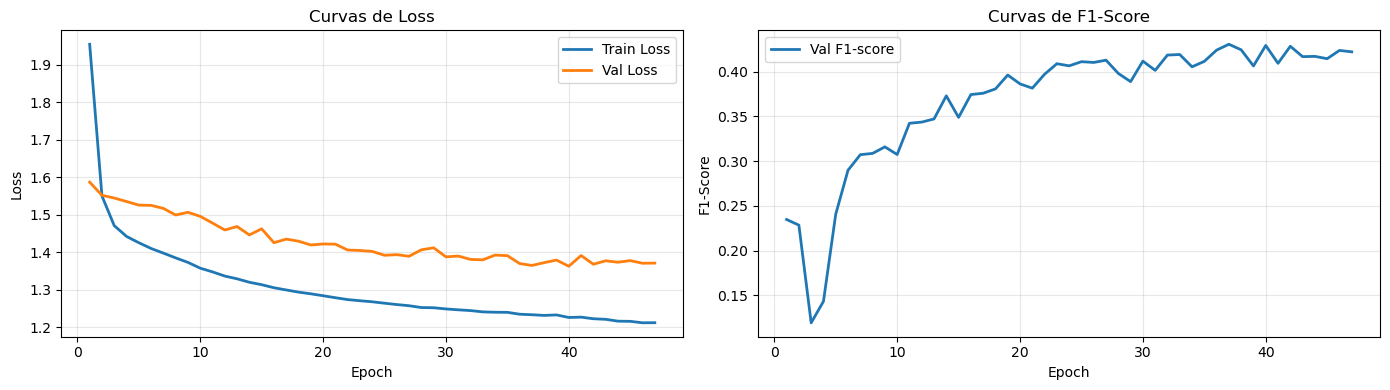

In [61]:
# Evaluar train

train_loss = model3.evaluate(X_train, y_train, verbose=0)

print(f"Train Loss: {train_loss:.4f}")

# Evaluar test

test_loss = model3.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")

# Visualización de curvas de entrenamiento
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs
epochs = range(1, len(history_model3.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_model3.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_model3.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, f1_callback.f1_scores, label='Val F1-score', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-Score')
ax2.set_title('Curvas de F1-Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


En esta ocasión podemos ver como el modelo mejora bastante en cuanto a los modelos anteriores. Aun así seguimos viendo **overfitting** ya que el modelo sigue mejorando en train sin mejorar en val.  

En cuanto al **F1-Score** podemos ver como el modelo **mejora bastante en las primeras 20 épocas pero despues se estanca** entorno a 0.40.

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


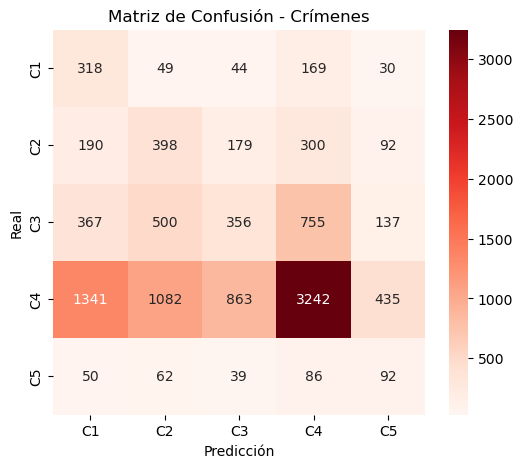


 Classification Report:
              precision    recall  f1-score   support

          C1       0.14      0.52      0.22       610
          C2       0.19      0.34      0.24      1159
          C3       0.24      0.17      0.20      2115
          C4       0.71      0.47      0.56      6963
          C5       0.12      0.28      0.17       329

    accuracy                           0.39     11176
   macro avg       0.28      0.36      0.28     11176
weighted avg       0.52      0.39      0.43     11176



In [62]:

# Matriz de confusión
y_pred_crime = model3.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

Hemos visto que el modelo ha mejorado utilizando **SMOTE**.  

Ahora vamos a probar una técnica híbrida entre *OverSampling y UnderSampling* llamada **SMOTETomek** que crea datos sintéticos para las clases minoritarias (SMOTE) y posteriormente elimina los datos ambigüos para evitar confundir al modelo y crear una separación entre clases más clara (Tomek Links).

## 4. Modelo 4 (SMOTETomek)

Tabla de especificaciones modelo 4:
| Especificación | Detalle | Valor Usado |
| :---: | :--- | :--- |
| **Arquitectura** | Capas Densas/Activación | 4 Capas (128, 64, 48, 32) con **ReLU** |
| **Capa de Salida** | Tipo de Clasificación | 5 neuronas con **Softmax** |
| **Regularización** | Dropout (en capas ocultas) | **0.5** (en las 4 capas) |
| **Normalización** | BatchNormalization | Sí (para estabilidad) |
| **Manejo de Desbalance** | Técnica de Preprocesamiento | **SMOTETomek** |
| **Optimizador** | Tipo y Tasa de Aprendizaje | **Adam** con $LR = 5e^{-4}$ |
| **Función de Pérdida** | Loss Function | **sparse\_categorical\_crossentropy** |
| **Métrica de Monitoreo** | Métrica Clave | **F1-Score (weighted)** |
| **EarlyStopping** | Monitoreo y Paciencia | `val_f1` (modo 'max'), paciencia **10** |
| **Learning Rate Sched.** | Reducción de Tasa de Aprendizaje | `ReduceLROnPlateau` (factor **0.5**, paciencia **5**) |
| **Épocas** | Máximo de iteraciones | **200** |
| **Tamaño de Lote (Batch)** | Batch size | **256** |

### 4.1. Creación modelo 4

In [63]:
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train.astype(float), y_train.astype(int))
X_train_res = X_train_res.astype(float) 
y_train_res = y_train_res.astype(int)

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_val, verbose=0), axis=1)
        f1 = f1_score(self.y_val, y_pred, average='weighted')
        self.f1_scores.append(f1)
        logs["val_f1"] = f1
        print(f" — val_f1: {f1:.4f}")

model4 = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(48, activation='relu'), 
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(5, activation='softmax')
])

optimizador = Adam(learning_rate=5e-4)

model4.compile(
    optimizer=optimizador,
    loss='sparse_categorical_crossentropy',
    metrics=[]
)

# Callbacks
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))
earlystopping = EarlyStopping(monitor='val_f1', mode="max", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1', 
    factor=0.5,       
    patience=5,       
    min_lr=1e-6,      
    mode='max',
    verbose=1
)

inicio = time.time()
history_model4 = model4.fit(
    X_train_res, y_train_res,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=256,
    callbacks=[f1_callback, earlystopping, lr_scheduler],
    verbose=1,
)
fin = time.time()
tiempo_entrenamiento = fin - inicio

Epoch 1/200
536/541 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1284 — val_f1: 0.0330
541/541 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.9028 - val_loss: 1.7273 - val_f1: 0.0330 - learning_rate: 5.0000e-04
Epoch 2/200
540/541 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5940 — val_f1: 0.0688
541/541 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.5595 - val_loss: 1.6451 - val_f1: 0.0688 - learning_rate: 5.0000e-04
Epoch 3/200
537/541 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4915 — val_f1: 0.1128
541/541 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.4788 - val_loss: 1.5942 - val_f1: 0.1128 - learning_rate: 5.0000e-04
Epoch 4/200
529/541 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4505 — val_f1: 0.1583
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4465 - val_loss: 1.5607 - val_f1: 0.1583 - learning_rate: 5.0000e-04
Epoch 5/200
540/541 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4309 — val_f1: 0.1958
541/541 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.4264 - val_loss: 1.5553 - val_f1: 0.1958 - l

In [64]:
print(f"Tiempo de entrenamiento (segundos): {tiempo_entrenamiento:.2f}")
observaciones = "Modelo 4. 4 capas ocultas con BatchNorm y Dropout. Función de activación ReLU. Entrenado con EarlyStopping y ReduceLROnPlateau. SMOTETomek para balanceo de clases."
y_pred_train,y_pred_test,accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test = calcular_metricas_keras(model4, X_train, y_train, X_test, y_test)
agregar_metrica('Modelo Red Neuronal', 'Modelo 4',accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,tiempo_entrenamiento,overfitting='Si',observaciones=observaciones)

Tiempo de entrenamiento (segundos): 294.77
RESULTADOS FINALES DEL MODELO
Accuracy (train): 0.4033
Recall (train): 0.4033
F1-score (train): 0.4310
Accuracy (test): 0.3711
Recall (test): 0.3711
F1-score (test): 0.4105
Métrica agregada correctamente a metrics_red_neuronal.csv


### 4.2. Evaluación modelo 4

Train Loss: 1.3081
Test Loss: 1.3900


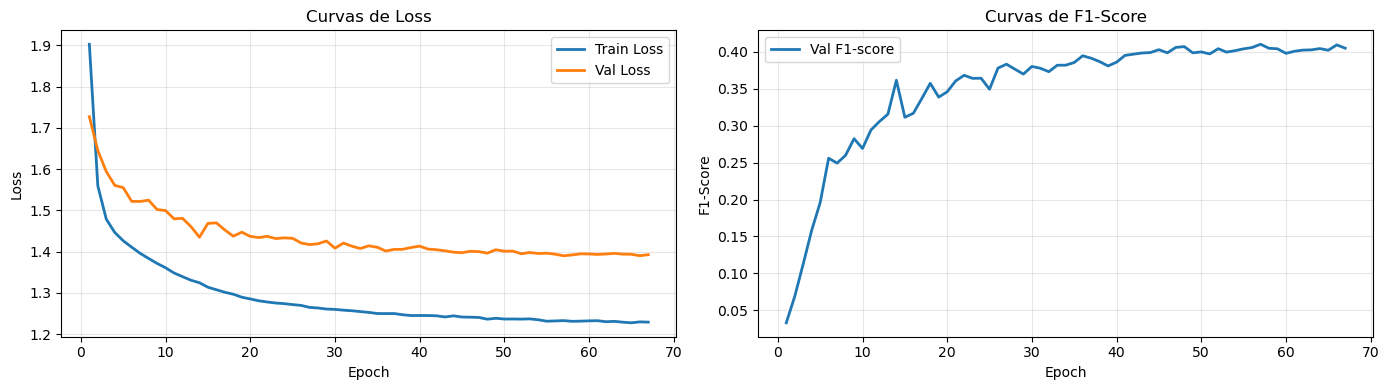

In [65]:
# Evaluar train

train_loss = model4.evaluate(X_train, y_train, verbose=0)

print(f"Train Loss: {train_loss:.4f}")

# Evaluar test

test_loss = model4.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")

# Visualización de curvas de entrenamiento
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Crear rango de epochs
epochs = range(1, len(history_model4.history['loss']) + 1)

# Loss
ax1.plot(epochs, history_model4.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs, history_model4.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curvas de Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, f1_callback.f1_scores, label='Val F1-score', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-Score')
ax2.set_title('Curvas de F1-Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Podemos ver que **SMOTETomek mejora un poco** en comparación con SMOTE, pero seguimos teniendo prácticamente los mismos problemas que teníamos antes.

350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


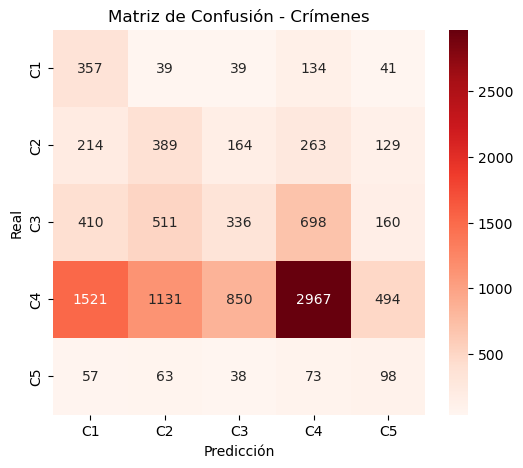


 Classification Report:
              precision    recall  f1-score   support

          C1       0.14      0.59      0.23       610
          C2       0.18      0.34      0.24      1159
          C3       0.24      0.16      0.19      2115
          C4       0.72      0.43      0.53      6963
          C5       0.11      0.30      0.16       329

    accuracy                           0.37     11176
   macro avg       0.28      0.36      0.27     11176
weighted avg       0.52      0.37      0.41     11176



In [66]:
# Matriz de confusión
y_pred_crime = model4.predict(X_test)
y_pred_crime_classes = np.argmax(y_pred_crime, axis=1)

cm = confusion_matrix(y_test, y_pred_crime_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=[f"C{i+1}" for i in range(5)],
            yticklabels=[f"C{i+1}" for i in range(5)])
plt.title('Matriz de Confusión - Crímenes')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

print("\n Classification Report:")
print(classification_report(y_test, y_pred_crime_classes, 
                          target_names=[f"C{i+1}" for i in range(5)]))

# 5. Evaluación general de todos los modelos

Resumen de Modelos por Rendimiento (F1-Score en Test)
| experimento   |   f1_test_avg |   f1_train_avg |   tiempo_entrenamiento_seg | overfitting   | observaciones                                                                                                                                                       |
|:--------------|--------------:|---------------:|---------------------------:|:--------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Baseline      |      0.491008 |       0.496097 |                    60.4664 | Si            | Modelo básico con 2 capas densas y función de activación ReLU en la capa oculta y Softmax en la capa de salida. Entrenado por 20 épocas con Adam default.           |
| Modelo 4      |      0.422978 |       0.438163 |                   167.637  | Si            | Modelo 4. 4 capas ocultas con BatchNorm y Dropout. Función de ac

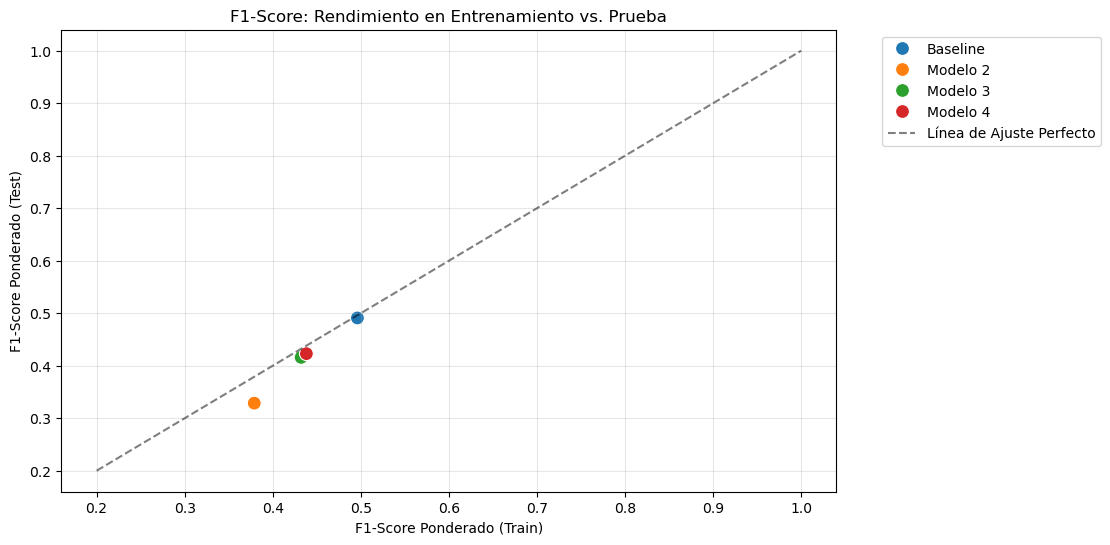

In [ ]:
df_evaluacion = pd.read_csv("metrics_red_neuronal.csv")
print("Resumen de Modelos por Rendimiento (F1-Score en Test)")
df_resumen = df_evaluacion[['experimento', 'f1_test_avg', 'f1_train_avg', 'tiempo_entrenamiento_seg', 'overfitting', 'observaciones']]
print(df_resumen.sort_values(by='f1_test_avg', ascending=False).to_markdown(index=False))

## 2. Visualizar la Brecha de Rendimiento (Train vs. Test)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_evaluacion, 
    x='f1_train_avg', 
    y='f1_test_avg', 
    hue='experimento', 
    s=100
)
#
plt.plot([0.2, 1.0], [0.2, 1.0], 'k--', alpha=0.5, label='Línea de Ajuste Perfecto')
plt.title('F1-Score: Rendimiento en Entrenamiento vs. Prueba')
plt.xlabel('F1-Score Ponderado (Train)')
plt.ylabel('F1-Score Ponderado (Test)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True, alpha=0.3)
plt.show()

#### Conclusiones finales:

Conclusiones sobre el Rendimiento:  
1. **Modelo de Máximo F1-Score Global (Baseline):** El Modelo Baseline logró el F1-Score más alto ($\mathbf{0.497}$). Sin embargo, como se vio en la matriz de confusión original, este modelo es inútil para la tarea de predicción de crímenes, ya que su alto rendimiento es un resultado de su **sesgo extremo** hacia la clase mayoritaria (**C4**, con un $\text{Recall}$ de $\approx 98.5\%$ y un $\text{Recall}$ de las clases minoritarias de $\approx 2-6\%$).
2. **Mejor Modelo de Generalización (Modelo 4):** El **Modelo 4** (*SMOTETomek*), con un $\text{F1-Score}$ de $\mathbf{0.439}$, es la solución más efectiva y robusta. Aunque su F1-Score es ligeramente inferior al Baseline, este modelo representa un compromiso real entre el Recall de la clase mayoritaria y el Recall de las clases minoritarias.

Conclusiones de la Matriz de Confusión:
|Clase|Recall del Baseline (Sin Balanceo)|Recall del Modelo 4 (SMOTETomek)|Observación|
|:---:|:---------------------------------|:-------------------------------|----------:|
|C1|≈2.3%|≈56.7%|Mejora significativa|
|C2|≈3.5%|≈31.7%|Mejora considerable|
|C3|≈1.6%|≈16.1%|Mejora mínima|
|C4|≈98.5%|≈49.9%|Empeora (necesario para equilibrar las clases)|
|C5|≈6.1%|≈30.7%|Mejora considerable|

***Modelo final:***  
Tras analizar las diferentes redes, el **Modelo 4** (*SMOTETomek*) es el modelo que mejor se ajusta a un resultado realista. No se ve tan sesgado como el modelo **Baseline** por una clase en concreto y proporciona mejores resultados que los modelos 2 y 3.